# Tarea 1: Perceptrón Multicapa
### EL4106 Inteligencia Computacional

Profesor de Cátedra: Pablo Estévez<br>
Profesor Auxiliar: Ignacio Reyes<br>

## Imports

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

import itertools
import warnings
from sklearn.metrics import confusion_matrix as sk_conf_mat

# Se imprime la version de Tensorflow
print('Tensorflow version', tf.__version__)
# Se imprime si es que se esta utilizando GPU o no
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    warnings.warn('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

Tensorflow version 2.6.0
Found GPU at: /device:GPU:0


## Preparación de la base de datos MNIST

In [2]:
# ----- Digito a identificar.
chosen_digit = 8

In [3]:
def process_dataset(images, labels, selected_class):
    """Revuelve datos y selecciona subconjunto segun la clase seleccionada.
    Aplana las imagenes para que tengan la forma de un vector de largo 28*28
    Normaliza imagenes para que en vez de tener valores entre [0,255] tengan 
    valores entre [0,1].
    
    Los datos de imagenes y etiquetas son revueltos, se seleccionan aquellos
    que coinciden con la etiqueta de la clase seleccionada, y un subconjunto
    del mismo tamaño que el anterior es seleccionado de entre todas las demas
    clases para obtener un problema balanceado.
    """
    # labels a formato one-hot
    aux_labels = np.zeros((labels.size, 10))
    aux_labels[np.arange(labels.size),labels] = 1
    labels = aux_labels
    # aplana imagenes
    images = np.reshape(
        images, [images.shape[0], images.shape[1]*images.shape[2]])
    shuffled_indexes = np.random.permutation(len(labels))  # Primer shuffle
    images = images[shuffled_indexes]
    labels = labels[shuffled_indexes]
    selected_column = labels[:, selected_class]
    selected_images_indexes = np.where(selected_column == 1)[0]
    selected_size = len(selected_images_indexes)
    non_selected_indexes_subset = np.where(selected_column == 0)[0][:selected_size]
    indexes = np.concatenate(
        (selected_images_indexes, 
        non_selected_indexes_subset),
        axis=0)
    # No queremos que el modelo primero vea todos los datos de una clase y
    # despues todos los de la otra, asi que volvemos a revolver.
    np.random.shuffle(indexes)
    images_subset = images[indexes]
    labels_subset = selected_column[indexes]
    labels_subset = np.array(labels_subset, dtype=np.int32)
    return images_subset/255.0, labels_subset


# Carga de la base de datos MNIST
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reserva 5,000 muestras para validacion
x_val = x_train[-5000:]
y_val = y_train[-5000:]
x_train = x_train[:-5000]
y_train = y_train[:-5000]


# Preprocesamiento de datos de entrenamiento, validacion y testing
training_images, training_labels = process_dataset(
    x_train,
    y_train,
    chosen_digit)
validation_images, validation_labels = process_dataset(
    x_val,
    y_val,
    chosen_digit)
testing_images, testing_labels = process_dataset(
    x_test,
    y_test,
    chosen_digit)
print('Processing ready.')

Processing ready.


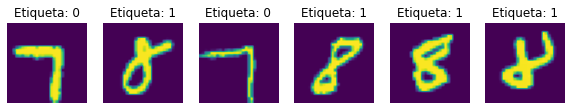

In [4]:
# Visualizacion de algunas imagenes de los datos de entrenamiento

chosen_idx = np.random.choice(training_images.shape[0], size=6, replace=False)

fig, ax = plt.subplots(1, 6, figsize=(10,5))
fig.set_facecolor('white')
for i, idx in enumerate(chosen_idx):
    image = training_images[idx, :]
    digit = training_labels[idx]
    ax[i].imshow(image.reshape((28, 28)))
    ax[i].set_title("Etiqueta: %d" % digit)
    ax[i].axis('off')

## Definición de Clasificador MLP

### Función de costo

In [5]:
def loss_fn(logits, labels, loss_function_name):
    """Calculo de la funcion de costo, donde se puede escoger entre 2 opciones; 
    xentropy o mse.
    
    Se aplica el loss 'loss_function_name' entre los labels reales y la salida
    de la MLP. Ademas, se calcula el accuracy.
    
    Args:
        logits: Tensor de dimensiones (batch_size, n_classes) con los logits
        de la salida de la MLP
        labels: Tensor de dimensiones (batch_size,) con las etiquetas reales.
        loss_function_name: 'cross_entropy' o 'mse', selecciona el costo.
    
    Returns:
        loss: Tensor escalar que corresponde al costo calculado.
        accuracy: Tensor escalar que corresponde al accuracy calculado.
    """
    
    # Codificacion 'one hot' para las etiquetas de clase
    n_classes = logits.shape[1]
    one_hot_labels = tf.one_hot(labels, n_classes)
    with tf.name_scope('loss'):
        if loss_function_name == 'cross_entropy':
            # Cross Entropy loss
            loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(
                    logits=logits,
                    labels=one_hot_labels),
                name='xentropy'
            )
        elif loss_function_name == 'mse':
            # Mean Squared Error loss
            probabilities = tf.nn.softmax(logits)
            loss = tf.reduce_mean(
                tf.square(one_hot_labels - probabilities),
                name='mse'
            )
        else:
            raise ValueError('Wrong value for loss_function_name')
    with tf.name_scope('accuracy'):
        predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
        correct_predictions = tf.equal(labels, predictions)
        accuracy = tf.reduce_mean(
            tf.cast(correct_predictions, tf.float32),
            name='accuracy')
    return loss, accuracy

### Clase de Clasificador MLP
Esta clase utiliza la funcion anteriores para entrenar el modelo.

In [6]:
class MLPClassifier(tf.keras.Model):
    """Implementacion de clasificador Perceptron Multicapa.
    """
    
    def __init__(
        self,
        n_features,
        layer_sizes,
        loss_function_name='cross_entropy',
        learning_rate=0.1,
        batch_size=32,
        max_epochs=100,
        early_stopping=None,
        logdir='logs'):
        """Construye un clasificador Perceptron Multicapa.
        
        Args:
            n_features: Entero que indica el numero de caracteristicas de las entradas.
            layer_sizes: Lista de enteros que indica el tamaño de cada capa de
            neuronas. La salida de la capa i-esima posee dimensiones
            (batch_size, layer_sizes[i]). El ultimo numero de la lista indica el
            tamaño de la capa de salida, que debe ser igual al numero de clases.
            loss_function_name: 'cross_entropy' o 'mse', selecciona el costo.
                Por defecto es 'cross_entropy'.
            learning_rate: Escalar que indica la tasa de aprendizaje. Al
                seleccionar Adam este parametro es ignorado. Por defecto es 0.1
            batch_size: Entero que indica el tamaño de los mini-batches para
                el entrenamiento de la red.
            max_epochs: Entero que indica el maximo numero de epocas de
                entrenamiento (pasadas completas por los datos de entrada) 
            early_stopping: Indica cuantas veces las verificaciones en la
                validacion deben indicar que el costo esta aumentando para
                realizar una detencion temprana. Por defecto es None, lo cual
                desactiva la detencion temprana.
            logdir: String que indica el directorio en donde guardar los
                archivos del entrenamiento. Por defecto es 'logs'.
        """
        
        # Inicializa atributos propios de un objeto del tipo tf.keras.Model
        super().__init__()
        # Agregar parametros al objeto
        self.n_features = n_features
        self.layer_sizes = layer_sizes
        self.loss_function_name = loss_function_name
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.early_stopping = early_stopping
        self.logdir = logdir
        # Inicializa capas del modelo
        self.layers_list = self._init_layers(layer_sizes)
        # Crea un objeto optimizador
        self.optimizer = tf.keras.optimizers.SGD(learning_rate=self.learning_rate)
        
    def _init_layers(self, layer_sizes):
        """Inicializa-crea los objetos de cada capa de la red MLP.

        Args:
          layer_sizes: Lista de enteros que indica el tamaño de cada capa de
              neuronas. La salida de la capa i-esima posee dimensiones
              (batch_size, layer_sizes[i]). El ultimo numero de la lista indica el
              tamaño de la capa de salida, que debe ser igual al numero de clases.

        Returns:
          layers_list: Lista de objetos asociados a cada capa creada.
        """
        n_layers = len(layer_sizes)
        layers_list = []
        # Inicializacion de capas del modelo
        layers_list.append(tf.keras.layers.InputLayer((self.n_features)))
        for i in range(n_layers):
            layers_list.append(tf.keras.layers.Dense(layer_sizes[i], name='dense_%i' % (i+1)))
            if i < n_layers - 1:
                # Inicializacion de funcion de activacion de capa oculta
                layers_list.append(tf.keras.layers.Activation(tf.nn.sigmoid))
            else:
                # Inicializacion de funcion de activacion de capa de salida
                layers_list.append(tf.keras.layers.Activation(tf.nn.softmax))
        return layers_list

    def call(self, x, training=False, get_logits=False):
        """Metodo que entrega la salida del modelo, 
        define el paso forward de la red neuronal, relacionando las capas 
        de la red MLP entre si. Se define la arquitectura del modelo.

        Args:
          x: Tensor de entrada de dimensiones (batch_size, n_features).
          training: Boolean que indica si se esta en fase de entrenamiento o no.
            En este caso es irrelevante, pero resulta util al definir capas que 
            tienen diferentes comportamientos durante entrenamiento y evaluacion
             como dropout o batch normalization 
          get_logits: Bolean que indica si como salida del modelo se obtienen los
            logits o las predicciones

        Returns:
          x: Tensor de salida de la red, de dimensiones (batch_size, n_classes).
        """
        for layer_index, layer in enumerate(self.layers_list):
            # se se desean los logits, se retorna la salida del modelo sin la ultima activacion
            if layer_index == (len(self.layers_list)-1) and get_logits==True:
                return x 
            x = layer(x)
        return x

    @tf.function
    def train_step(self, x_data, y_labels):
        """Metodo que realiza la actualizacion por gradiente.

        Se aplica el algoritmo de optimizacion 'sgd' para ejecutar una
        iteracion de minimizacion por gradiente sobre el loss del modelo.

        Args:
          x_data: datos de entrenamientos sobre los que calcular la loss.
          y_labels: etiquetas de entrenamiento sobre las que calcular la loss.

        Returns:
          loss: el valor de la funcion de costo para x_data, y_labels.
          accuracy: porcentaje de aciertos entre y_labels y las predicciones sobre x_data.
        """
        with tf.GradientTape() as tape:
            # training=True is only needed if there are layers with different
            # behavior during training versus inference (e.g. Dropout).
            logits = self.call(x_data, training=True, get_logits=True)
            loss, accuracy = loss_fn(logits, y_labels, self.loss_function_name)
            gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return loss, accuracy

    @tf.function
    def eval_step(self, x_data, y_labels):
        """Metodo que evalua la funcion de costo y el accuracy del modelo.

        Args:
          x_data: datos sobre los que calcular la loss y accuracy.
          y_labels: etiquetas sobre las que calcular la loss y accuracy.

        Returns:
          loss: el valor de la funcion de costo para x_data, y_labels.
          accuracy: porcentaje de aciertos entre y_labels y las predicciones sobre x_data.
        """
        logits = self.call(x_data, training=False, get_logits=True)
        loss, accuracy = loss_fn(logits, y_labels, self.loss_function_name)
        return loss, accuracy

    @tf.function
    def prediction_step(self, x_data):
        """Metodo que retorna predicciones para x_data

        Args:
          x_data: datos a predecir.

        Returns:
          predictions: predicciones para x_data
        """
        predictions = self.call(x_data, training=False, get_logits=False)
        return predictions

    def write_to_train_summary(self, train_summary_writer, step, loss, accuracy):
        """Metodo que calcula metricas y parametros a ser monitoreados en tensorboard.
        Monitorea histograma de parametros y metricas del modelo. Para datos de entrenamiento

        Args:
          train_summary_writer: Summary writer de entrenamiento
          step: iteracion del entrenamiento
          loss: valor de la funcion de costo para datos de entrenamiento
          accuracy: accuracy para datos de entrenamiento
        """
        with train_summary_writer.as_default():
            for layer_i in self.layers_list:
                layer_name = layer_i.name
                if 'dense' in layer_name:
                    weights, biases = layer_i.get_weights()
                    tf.summary.histogram(layer_name + '_weights', weights, step=step)
                    tf.summary.histogram(layer_name + '_biases', biases, step=step)
            tf.summary.scalar(self.loss_function_name + '_loss', loss, step=step)  
            tf.summary.scalar('accuracy', accuracy, step=step)  

    def write_to_val_summary(self, val_summary_writer, step, loss, accuracy):
        """Metodo que calcula metricas a ser monitoreados en tensorboard.
        Monitorea metricas del modelo. Para datos de validacion

        Args:
          validacion_summary_writer: Summary writer de validacion
          step: iteracion del entrenamiento
          loss: valor de la funcion de costo para datos de validacion
          accuracy: accuracy para datos de validacion
        """
        with val_summary_writer.as_default():
            tf.summary.scalar(self.loss_function_name + '_loss', loss, step=step)  
            tf.summary.scalar('accuracy', accuracy, step=step)  
    
        
    def fit(self, X_train, y_train, X_val, y_val):
        """Entrenamiento del clasificador con los hiperparametros escogidos.
        
        Args:
            X_train: Entradas del entrenamiento con dimensiones (n_ejemplos, n_features).
            y_train: Etiquetas del entrenamiento con dimensiones (n_ejemplos,)
            X_train: Entradas de la validacion con dimensiones (n_ejemplos, n_features).
            y_train: Etiquetas de la validacion con dimensiones (n_ejemplos,)
            
        Returns:
            train_stats: Diccionario con datos historicos del entrenamiento.
        """
        # Creacion de 'writers' que guardan datos para Tensorboard
        train_summary_writer = tf.summary.create_file_writer(
            self.logdir + '/train')
        val_summary_writer = tf.summary.create_file_writer(self.logdir + '/val')
        print('\n\n[Beginning training of MLP at logdir "%s"]\n' % (self.logdir,))    
        # Definicion de variables utiles para el entrenamiento
        n_batches = int(X_train.shape[0] / self.batch_size)
        prev_validation_loss = 100.0
        validation_period = 100
        early_stop_flag = False
        start_time = time.time()
        iteration_history = []
        train_loss_history = []
        train_acc_history = []
        val_loss_history = []
        val_acc_history = []
        # Se crea dataset para iterar sobre los batch de los datos de entreneminto. 
        # Para cada nueva epoca, se hacer un shuffle al set de train
        train_dataset = tf.data.Dataset.from_tensor_slices(
            (X_train, y_train)).shuffle(X_train.shape[0]).batch(self.batch_size)
        # Ciclo que recorre una epoca completa de los datos cada vez
        for epoch in range(self.max_epochs):
            if early_stop_flag:
                # Si early stopping se activo, detener el entrenamiento
                break            
            # Ciclo que recorre los mini batches del set de train
            for i, (X_batch, y_batch) in enumerate(train_dataset):
                if early_stop_flag:
                    # Si early stopping se activo, detener el entrenamiento
                    break  
                iteration = epoch * n_batches + i                    
                # Ejecutar una iteracion de gradiente
                self.train_step(X_batch, y_batch)
                # Obtener estadisticas del entrenamiento
                if iteration % validation_period == 0:
                    iteration_history.append(iteration)
                    # Estadisticas en el set de validacion
                    val_loss, val_acc = self.eval_step(X_val, y_val)
                    # Escribir estadisticas de validacion en tensorboard
                    self.write_to_val_summary(
                        val_summary_writer, iteration, val_loss, val_acc)
                    val_loss_history.append(val_loss)
                    val_acc_history.append(val_acc)
                    # Estadisticas en el set de entrenamiento
                    train_loss, train_acc = self.eval_step(X_train, y_train)
                    # Escribir estadisticas e histogramas de parametros de 
                    # entrenamiento en tensorboard
                    self.write_to_train_summary(
                        train_summary_writer, iteration, train_loss, train_acc)
                    train_loss_history.append(train_loss)
                    train_acc_history.append(train_acc)
                    
                    print('Epoch: %d/%d, iter: %d. ' %
                          (epoch+1, self.max_epochs, iteration), end='')
                    print('Loss (train/val): %.3f / %.3f. Val. acc: %.1f%%' %
                          (train_loss, val_loss, val_acc * 100), end='')
                    
                    # Chequear condicion de early_stopping
                    if self.early_stopping is not None:
                        if val_loss > prev_validation_loss:
                            validation_checks += 1
                        else:
                            validation_checks = 0
                            prev_validation_loss = val_loss
                        print(', Val. checks: %d/%d' %
                              (validation_checks, self.early_stopping))
                        if validation_checks >= self.early_stopping:
                            early_stop_flag = True
                            print('Early stopping')
                    else:
                        print('')
            elap_time = time.time()-start_time
            print("Epoch finished. Elapsed time %1.4f [s]\n" % (elap_time,))
        # Guardar estadisticas en un diccionario
        train_stats = {
            'iteration_history': np.array(iteration_history),
            'train_loss_history': np.array(train_loss_history),
            'train_acc_history': np.array(train_acc_history),
            'val_loss_history': np.array(val_loss_history),
            'val_acc_history': np.array(val_acc_history)
        }
        # Guardar grafo de evaluacion en tensorboard
        self.write_graph_to_summary(train_summary_writer, X_train)
        return train_stats

    def write_graph_to_summary(self, train_summary_writer, X_train):
        """Metodo que guarda el grafo de evaluacion (arquitectura del modelo)
        en tensorboard. Se guardan las operaciones involugradas en un passo forward
        o self.call del modelo

        Args:
          train_summary_writer: Summary writer para datos de entrenamiento.
          X_train: Datos de entrenamiento
        """
        logdir = self.logdir + '/graph'
        tf.summary.trace_on(graph=True, profiler=False)
        predicted_proba = self.prediction_step(X_train)
        with train_summary_writer.as_default():
            tf.summary.trace_export(
                name="prediction_step",
                step=0,
                profiler_outdir=logdir)
            tf.summary.trace_off()

    def predict_proba(self, X):
        """Retorna las probabilidades de clase para los datos de entrada.
              
        Args:
            X: datos de entrada
        
        Returns:
            predicted_proba.numpy(): Arreglo numpy de las probabilidades de 
              cada clase, para cada muestra de X.
        """
        # Obtener las probabilidades de salida de cada clase
        predicted_proba = self.prediction_step(X)
        return predicted_proba.numpy()
    
    def predict_label(self, X):
        """Retorna la etiqueta predicha para los datos de entrada.
        
        Args:
            X: datos de entrada
        
        Returns:
            predicted_labels: Arreglo numpy de las predicciones de cada muestra de X.
        """
        # Obtener la probabilidad de cada clase
        predicted_proba = self.prediction_step(X)
        # Etiquetar segun la etiqueta mas probable
        predicted_labels = np.argmax(predicted_proba, axis=1)
        return predicted_labels

## Entrenamiento de MLP

In [7]:
# ----- Directorio para logs
experiment_name = "experiment_15"

# --- NO TOCAR
logdir_father = "./tarea_1_logs/"
logdir = logdir_father + experiment_name

In [8]:
run_n_times = 5
stats_history = []
for run in range(run_n_times):
    # ----- Creacion de MLP
    mlp = MLPClassifier(
        n_features=28*28,
        layer_sizes=[25, 2],
        loss_function_name='cross_entropy',
        learning_rate=10,
        batch_size=32,
        max_epochs=100,
        early_stopping=15,
        logdir=logdir+'/run_%d' % run)

    # ----- Entrenamiento de MLP
    train_stats = mlp.fit(training_images, training_labels, validation_images, validation_labels)
    stats_history.append(train_stats)



[Beginning training of MLP at logdir "./tarea_1_logs/experiment_15/run_0"]

Epoch: 1/100, iter: 0. Loss (train/val): 12.908 / 12.906. Val. acc: 50.0%, Val. checks: 0/15
Epoch: 1/100, iter: 100. Loss (train/val): 3.690 / 3.690. Val. acc: 50.0%, Val. checks: 0/15
Epoch: 1/100, iter: 200. Loss (train/val): 3.334 / 3.334. Val. acc: 50.0%, Val. checks: 0/15
Epoch: 1/100, iter: 300. Loss (train/val): 1.716 / 1.716. Val. acc: 50.0%, Val. checks: 0/15
Epoch finished. Elapsed time 1.8061 [s]

Epoch: 2/100, iter: 400. Loss (train/val): 4.082 / 4.081. Val. acc: 50.0%, Val. checks: 1/15
Epoch: 2/100, iter: 500. Loss (train/val): 5.618 / 5.618. Val. acc: 50.0%, Val. checks: 2/15
Epoch: 2/100, iter: 600. Loss (train/val): 4.176 / 4.176. Val. acc: 50.0%, Val. checks: 3/15
Epoch finished. Elapsed time 2.4178 [s]

Epoch: 3/100, iter: 700. Loss (train/val): 0.938 / 0.938. Val. acc: 50.0%, Val. checks: 0/15
Epoch: 3/100, iter: 800. Loss (train/val): 4.036 / 4.036. Val. acc: 50.0%, Val. checks: 1/15
Epo

Epoch: 3/100, iter: 700. Loss (train/val): 1.422 / 1.354. Val. acc: 64.2%, Val. checks: 1/15
Epoch: 3/100, iter: 800. Loss (train/val): 1.149 / 1.159. Val. acc: 50.0%, Val. checks: 2/15
Epoch: 3/100, iter: 900. Loss (train/val): 1.150 / 1.021. Val. acc: 75.9%, Val. checks: 3/15
Epoch: 3/100, iter: 1000. Loss (train/val): 0.829 / 0.785. Val. acc: 82.7%, Val. checks: 0/15
Epoch finished. Elapsed time 2.4745 [s]

Epoch: 4/100, iter: 1100. Loss (train/val): 2.356 / 2.107. Val. acc: 73.7%, Val. checks: 1/15
Epoch: 4/100, iter: 1200. Loss (train/val): 0.596 / 0.573. Val. acc: 84.3%, Val. checks: 0/15
Epoch: 4/100, iter: 1300. Loss (train/val): 0.509 / 0.507. Val. acc: 79.6%, Val. checks: 0/15
Epoch finished. Elapsed time 3.1251 [s]

Epoch: 5/100, iter: 1400. Loss (train/val): 0.493 / 0.495. Val. acc: 81.7%, Val. checks: 0/15
Epoch: 5/100, iter: 1500. Loss (train/val): 1.164 / 1.101. Val. acc: 78.4%, Val. checks: 1/15
Epoch: 5/100, iter: 1600. Loss (train/val): 0.804 / 0.762. Val. acc: 78.7%,

Epoch: 1/100, iter: 300. Loss (train/val): 7.634 / 7.633. Val. acc: 50.0%, Val. checks: 3/15
Epoch finished. Elapsed time 1.1056 [s]

Epoch: 2/100, iter: 400. Loss (train/val): 1.950 / 1.950. Val. acc: 50.0%, Val. checks: 4/15
Epoch: 2/100, iter: 500. Loss (train/val): 2.666 / 2.666. Val. acc: 50.0%, Val. checks: 5/15
Epoch: 2/100, iter: 600. Loss (train/val): 9.494 / 9.495. Val. acc: 50.0%, Val. checks: 6/15
Epoch finished. Elapsed time 1.7789 [s]

Epoch: 3/100, iter: 700. Loss (train/val): 1.354 / 1.354. Val. acc: 50.0%, Val. checks: 7/15
Epoch: 3/100, iter: 800. Loss (train/val): 1.750 / 1.750. Val. acc: 50.0%, Val. checks: 8/15
Epoch: 3/100, iter: 900. Loss (train/val): 1.980 / 1.980. Val. acc: 50.0%, Val. checks: 9/15
Epoch: 3/100, iter: 1000. Loss (train/val): 5.610 / 5.609. Val. acc: 50.0%, Val. checks: 10/15
Epoch finished. Elapsed time 2.4383 [s]

Epoch: 4/100, iter: 1100. Loss (train/val): 10.100 / 10.099. Val. acc: 50.0%, Val. checks: 11/15
Epoch: 4/100, iter: 1200. Loss (tr

### Tasa de acierto en validación computada sobre varias ejecuciones.

In [9]:
val_acc_history = np.array([run['val_acc_history'][-1] for run in stats_history])
val_acc_mean = val_acc_history.mean()
val_acc_std = val_acc_history.std()
print('Validation accuracy %.3f +/- %.3f' % (val_acc_mean, val_acc_std))
print(val_acc_history)

train_acc_history = np.array([run['train_acc_history'][-1] for run in stats_history])
train_acc_mean = train_acc_history.mean()
train_acc_std = train_acc_history.std()
print('Train accuracy %.3f +/- %.3f' % (train_acc_mean, train_acc_std))
print(train_acc_history)

Validation accuracy 0.580 +/- 0.160
[0.5       0.5       0.8987854 0.5       0.5      ]
Train accuracy 0.580 +/- 0.160
[0.5       0.5       0.9009707 0.5       0.5      ]


## Visualización de Resultados

### Algunas estadísticas del entrenamiento

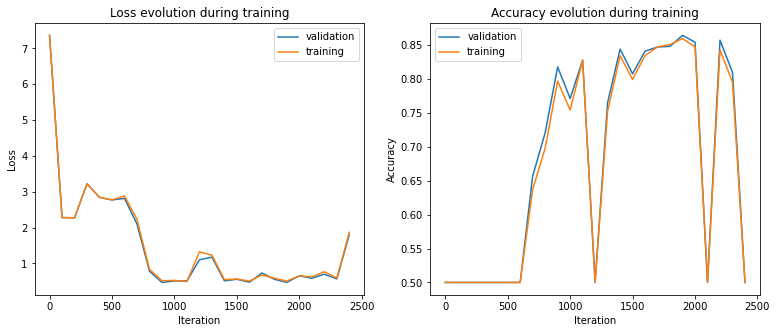

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
fig.set_facecolor('white')

ax[0].plot(train_stats['iteration_history'], train_stats['val_loss_history'], label='validation')
ax[0].plot(train_stats['iteration_history'], train_stats['train_loss_history'], label='training')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss evolution during training')
ax[0].legend()

ax[1].plot(train_stats['iteration_history'], train_stats['val_acc_history'], label='validation')
ax[1].plot(train_stats['iteration_history'], train_stats['train_acc_history'], label='training')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy evolution during training')
ax[1].legend()

### Estadísticas del desempeño final

Confusion matrix, without normalization
[[  0 974]
 [  0 974]]
Training results:
TP: 5357, TN: 0, FP: 5357, FN: 0
50.0000% Accuracy (Porcentaje de clasificaciones correctas)
50.0000% Precision
100.0000% Recall

Validation results:
TP: 494, TN: 0, FP: 494, FN: 0
50.0000% Accuracy (Porcentaje de clasificaciones correctas)
50.0000% Precision
100.0000% Recall

Test results:
TP: 974, TN: 0, FP: 974, FN: 0
50.0000% Accuracy (Porcentaje de clasificaciones correctas)
50.0000% Precision
100.0000% Recall



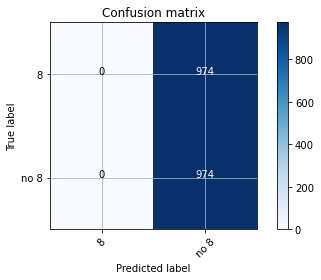

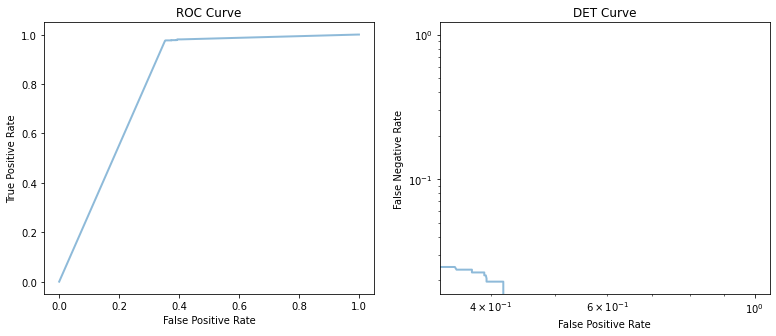

In [11]:
def confusion_matrix(labels, predictions):
    """Calcula la matriz de confusion.
    
    Args:
        labels: Array binario 1-D con las etiquetas reales.
        predictions: Array binario 1-D con las predicciones.
        
    Returns:
        TP: Numero de verdaderos positivos.
        FP: Numero de falsos positivos.
        FN: Numero de falsos negativos.
        TN: Numero de verdaderos negativos.
    """
    # Map labels and predictions to {0, 1, 2, 3}
    encoded_data = 2 * labels + predictions  
    TN = np.sum(encoded_data == 0)  # True negatives
    FP = np.sum(encoded_data == 1)  # False positives
    FN = np.sum(encoded_data == 2)  # False negatives
    TP = np.sum(encoded_data == 3)  # True positives
    return TP, FP, FN, TN


def performance_metrics(TP, FP, FN, TN):
    """Calcula metricas de desempeño.
    
    Args:
        TP: Numero de verdaderos positivos.
        FP: Numero de falsos positivos.
        FN: Numero de falsos negativos.
        TN: Numero de verdaderos negativos.
    
    Returns:
        accuracy: Porcentaje de clasificaciones correctas del detector.
        precision: Precision del detector.
        recall: Recall/Sensibilidad del detector.
    """
    accuracy = 100.0 * (TP + TN) / (TP + TN + FP + FN)
    precision = 100.0 * TP / (TP + FP)
    recall = 100.0 * TP / (TP + FN)
    print('TP: %d, TN: %d, FP: %d, FN: %d' %(TP,TN,FP,FN))
    print('%1.4f%% Accuracy (Porcentaje de clasificaciones correctas)' % (accuracy))
    print('%1.4f%% Precision' % (precision))
    print('%1.4f%% Recall' % (recall))
    print('')
    return accuracy, precision, recall


def roc_curve(labels, probabilities):
    """Calcula la curva ROC.
    
    Args:
        labels: Array binario 1-D con las etiquetas reales.
        probabilities: Array 1-D continuo en el rango [0, 1] con las
            probabilidades de la clase 1.
        
    Returns:
        tpr: Array 1-D con los valores de Tasa de Verdaderos Positivos (TPR).
        fpr: Array 1-D con los valores de Tasa de Falsos Positivos (FPR).
    """
    tpr = []
    fpr = []
    for threshold in np.linspace(0, 1, 1000):
        probabilities_with_threshold = (probabilities > threshold).astype(np.float)
        TP, FP, FN, TN = confusion_matrix(
            labels, 
            probabilities_with_threshold)
        tpr.append(TP/(TP+FN))
        fpr.append(FP/(FP+TN))
    return np.array(tpr), np.array(fpr)
  

def detection_performance_given_threshold(true_labels, prediction, threshold):
    probabilities_with_threshold = (prediction > threshold).astype(np.float)
    TP, FP, FN, TN = confusion_matrix(
        true_labels, 
        probabilities_with_threshold)    
    return TP, FP, FN, TN       

  
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

predicted_train_labels = mlp.predict_label(training_images)
predicted_val_labels = mlp.predict_label(validation_images)
predicted_test_labels = mlp.predict_label(testing_images)

cnf_matrix = sk_conf_mat(testing_labels, predicted_test_labels)

# Plot non-normalized confusion matrix
plt.figure()
plt.grid('off')
plt.gcf().set_facecolor('white')
plot_confusion_matrix(cnf_matrix, classes=['%d' % chosen_digit, 'no %d' % chosen_digit],
                      title='Confusion matrix')


print('Training results:')
TP, FP, FN, TN = confusion_matrix(training_labels, predicted_train_labels)
accuracy, precision, recall = performance_metrics(TP, FP, FN, TN)

print('Validation results:')
TP, FP, FN, TN = confusion_matrix(validation_labels, predicted_val_labels)
accuracy, precision, recall = performance_metrics(TP, FP, FN, TN)

print('Test results:')
TP, FP, FN, TN = confusion_matrix(testing_labels, predicted_test_labels)
accuracy, precision, recall = performance_metrics(TP, FP, FN, TN)

predicted_test_proba = mlp.predict_proba(testing_images)
tpr, fpr = roc_curve(testing_labels, predicted_test_proba[:, 1])

fig, ax = plt.subplots(1, 2, figsize=(13, 5))
fig.set_facecolor('white')

ax[0].set_title('ROC Curve')
ax[0].plot(fpr, tpr, linewidth=2, alpha=0.5)
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')

ax[1].set_title('DET Curve')
ax[1].plot(fpr, 1.0 - tpr, linewidth=2, alpha=0.5)
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('False Negative Rate')
ax[1].set_yscale('log')
ax[1].set_xscale('log')

### Performance según umbral de clasificación

In [12]:
predicted_validation_proba = mlp.predict_proba(validation_images)
TP, FP, FN, TN = detection_performance_given_threshold(validation_labels, predicted_validation_proba[:, 1], threshold=0.5)
print('TP: %d, TN: %d, FP: %d, FN: %d' %(TP,TN,FP,FN))

TP: 494, TN: 0, FP: 494, FN: 0


### Visualización de clasificaciones en el test

True Positives:


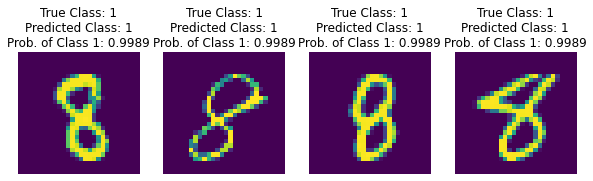

True Negatives:


UnboundLocalError: local variable 'i' referenced before assignment

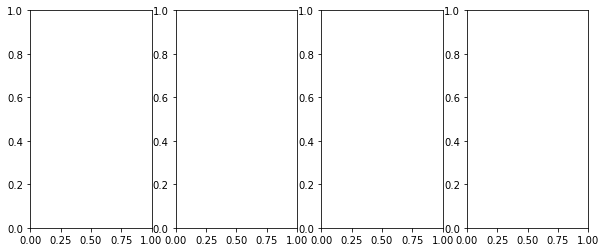

In [13]:
def show_classifications(images, labels, probabilities, result_type='TP'):
    """ Muestra ejemplos de imagenes para tipos de errores.
    
    Args:
        images: Array de dimensiones (n_ejemplos, n_pixeles) con imagenes.
        labels: Array de dimensiones (n_ejemplos,) con las etiquetas reales.
        probabilities: Array de dimensiones (n_ejemplos,) con las probabilidades
            de la clase 1.
        result_type: 'TP', 'FP', 'FN', o 'TP', tipo de error a mostrar.
    """
    dict_types = {'TN': 0, 'FP': 1, 'FN': 2, 'TP': 3}
    predictions = (probabilities > 0.5).astype(np.int32)
    encoded_data = 2 * labels + predictions 
    useful = np.where(encoded_data == dict_types[result_type])[0]
    size = min(4, useful.shape[0])
    chosen = np.random.choice(useful, size=size, replace=False)
    fig, ax = plt.subplots(1, 4, figsize=(10,4))
    fig.set_facecolor('white')
    for i, idx in enumerate(chosen):
        image = images[idx, :]
        digit = labels[idx]
        predicted_label = predictions[idx]
        proba = probabilities[idx]
        ax[i].imshow(image.reshape((28, 28)))
        ax[i].set_title("True Class: %d\nPredicted Class: %d\nProb. of Class 1: %1.4f"
                        % (digit, predicted_label, proba))
        ax[i].axis('off')
    for j in range(i+1, 4):
        ax[j].axis('off')
    plt.show()


predicted_test_proba = mlp.predict_proba(testing_images)
predicted_test_proba = predicted_test_proba[:, 1]

print('True Positives:')
show_classifications(testing_images, testing_labels, predicted_test_proba , result_type='TP')

print('True Negatives:')
show_classifications(testing_images, testing_labels, predicted_test_proba , result_type='TN')

print('False Positive:')
show_classifications(testing_images, testing_labels, predicted_test_proba , result_type='FP')

print('False Negative:')
show_classifications(testing_images, testing_labels, predicted_test_proba , result_type='FN')

Si quieren borrar su log_dir, utilicen lo siguiente:

Ejecutar comandos en bash
* %%bash

para mirar lo que hay en el directorio actual:
* ls 

para borrar la carpeta "tarea_1_logs"
* rm -r tarea_1_logs

buscar procesos asociados a tensorboard
* ps aux | grep tensorboard

terminar un proceso
* kill -9 process_id (process_id es el pid del proceso)




In [ ]:
#%%bash
#ls tarea_1_logs/exp_xentropy

In [ ]:
#!rm -r tarea_1_logs